In [1]:
from animalclef.spark import get_spark

spark = get_spark(memory="1g")

25/05/19 01:03:05 WARN Utils: Your hostname, hawksbill-vm resolves to a loopback address: 127.0.1.1; using 192.168.10.12 instead (on interface ens18)
25/05/19 01:03:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/19 01:03:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/19 01:03:05 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [2]:
from pathlib import Path
from pyspark.sql import functions as F

root = Path("~/scratch/animalclef").expanduser()

# split 0.6 train, 0.5 val/test, 0.8 known/unknown
df = (
    spark.read.json(
        f"{root}/processed/submissions/*/*/test_best_threshold.json", multiLine=True
    )
    .withColumn("filename", F.input_file_name())
    .withColumn(
        "model", F.udf(lambda p: Path(p).parts[-3], "string")(F.col("filename"))
    )
    .withColumn(
        "epoch", F.udf(lambda p: Path(p).parts[-2], "string")(F.col("filename"))
    )
    .drop("filename")
).where(F.col("model").like("%megadescriptor%"))
df.show(n=2, vertical=True)

-RECORD 0-------------------------------
 baks            | 0.8017003716187039   
 baus            | 0.9550267584368615   
 crossover_score | 0.8466736131818424   
 mad             | 0.27407121658325195  
 median          | 0.7446451187133789   
 num_neighbors   | 1.0                  
 score           | 0.8750116040057058   
 threshold       | -0.8888888888888884  
 model           | megadescriptor-no... 
 epoch           | head_epoch=090       
-RECORD 1-------------------------------
 baks            | 0.7276268226310905   
 baus            | 0.9049175396799702   
 crossover_score | 0.8227092829511202   
 mad             | 0.2650737166404724   
 median          | 0.7628355622291565   
 num_neighbors   | 1.0                  
 score           | 0.8114445601151569   
 threshold       | -0.8888888888888884  
 model           | megadescriptor-no... 
 epoch           | head_epoch=010       
only showing top 2 rows



In [3]:
df.select("model", "epoch", "score").orderBy(F.desc("score")).show(n=10)
df.select("model", "epoch", "score").orderBy(F.asc("score")).show(n=10)

+--------------------+--------------+------------------+
|               model|         epoch|             score|
+--------------------+--------------+------------------+
|megadescriptor-no...|head_epoch=070|0.8777832366717985|
|megadescriptor-no...|head_epoch=020|0.8754879464492042|
|megadescriptor-no...|          head|0.8753075722320314|
|megadescriptor-no...|head_epoch=090|0.8750116040057058|
|megadescriptor-no...|head_epoch=030|0.8731882314635765|
|megadescriptor-no...|head_epoch=050|0.8727426458721895|
|megadescriptor-no...|head_epoch=080|0.8605930056952016|
|megadescriptor-no...|head_epoch=040|0.8564425264661437|
|megadescriptor-no...|head_epoch=060|0.8558697839526762|
|megadescriptor-no...|head_epoch=010|0.8114445601151569|
+--------------------+--------------+------------------+

+--------------------+--------------+------------------+
|               model|         epoch|             score|
+--------------------+--------------+------------------+
|megadescriptor-no...|head_epo

Text(0.5, 1.0, 'DINO triplet score over epoch')

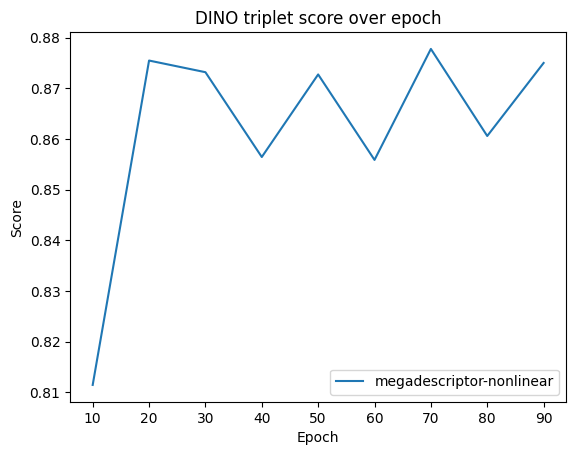

25/05/19 01:03:22 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [ ]:
from matplotlib import pyplot as plt

for row in df.select("model").distinct().collect():
    pdf = (
        df.where(f"model = '{row.model}' and epoch like '%=%'")
        .orderBy("epoch")
        .toPandas()
    )

    plt.plot(
        pdf["epoch"].str.split("=", expand=True)[1].astype(int),
        pdf["score"],
        label=row.model,
    )
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("DINO triplet score over epoch")